In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#splitting imports
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
#model imports
from sklearn.linear_model import LinearRegression
import xgboost
#evaluation imports
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

In [2]:
#reading data
data=pd.read_csv('DS3_C6_S1_Regression_StoreSales_Data_Project.csv')
data

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0               FDA15         9.30          Low Fat         0.016047   
1               DRC01         5.92          Regular         0.019278   
2               FDN15        17.50          Low Fat         0.016760   
3               FDX07        19.20          Regular         0.074402   
4               NCD19         8.93          Low Fat         0.064299   
...               ...          ...              ...              ...   
14199           FDB58        10.50          Regular         0.013496   
14200           FDD47         7.60          Regular         0.142991   
14201           NCO17        10.00          Low Fat         0.073529   
14202           FDJ26        15.30          Regular         0.064709   
14203           FDU37         9.50          Regular         0.104720   

                   Item_Type  Item_MRP Outlet_Identifier  \
0                      Dairy  249.8092            OUT049   
1                Soft Drinks   48.2692            OUT018   
2                       Meat  141.6180            OUT049   
3      Fruits and Vegetables  182.0950            OUT010   
4                  Household   53.8614            OUT013   
...                      ...       ...               ...   
14199            Snack Foods  141.3154            OUT046   
14200          Starchy Foods  169.1448            OUT018   
14201     Health and Hygiene  118.7440            OUT045   
14202                 Canned  214.6218            OUT017   
14203                 Canned   79.7960            OUT045   

       Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                           1999      Medium               Tier 1   
1                           2009      Medium               Tier 3   
2                           1999      Medium               Tier 1   
3                           1998      Medium               Tier 3   
4                           1987        High               Tier 3   
...                          ...         ...                  ...   
14199                       1997       Small               Tier 1   
14200                       2009      Medium               Tier 3   
14201                       2002       Small               Tier 2   
14202                       2007       Small               Tier 2   
14203                       2002       Small               Tier 2   

             Outlet_Type  Item_Outlet_Sales  
0      Supermarket Type1          3735.1380  
1      Supermarket Type2           443.4228  
2      Supermarket Type1          2097.2700  
3          Grocery Store           732.3800  
4      Supermarket Type1           994.7052  
...                  ...                ...  
14199  Supermarket Type1                NaN  
14200  Supermarket Type2                NaN  
14201  Supermarket Type1                NaN  
14202  Supermarket Type1                NaN  
14203  Supermarket Type1                NaN  

[14204 rows x 12 columns]

## Data Preprocessing

In [3]:
data.shape #shape of data

(14204, 12)

In [4]:
data.describe() #description of data

Item_Weight  Item_Visibility      Item_MRP  Outlet_Establishment_Year  \
count  14204.000000     14204.000000  14204.000000               14204.000000   
mean      12.793380         0.070301    141.004977                1997.830681   
std        4.651716         0.048621     62.086938                   8.371664   
min        4.555000         0.003575     31.290000                1985.000000   
25%        8.710000         0.033143     94.012000                1987.000000   
50%       12.600000         0.062347    142.247000                1999.000000   
75%       16.750000         0.094037    185.855600                2004.000000   
max       21.350000         0.328391    266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [5]:
data.dtypes #datatypes of features

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [6]:
null=data.isnull().sum() #checking for null values
null

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

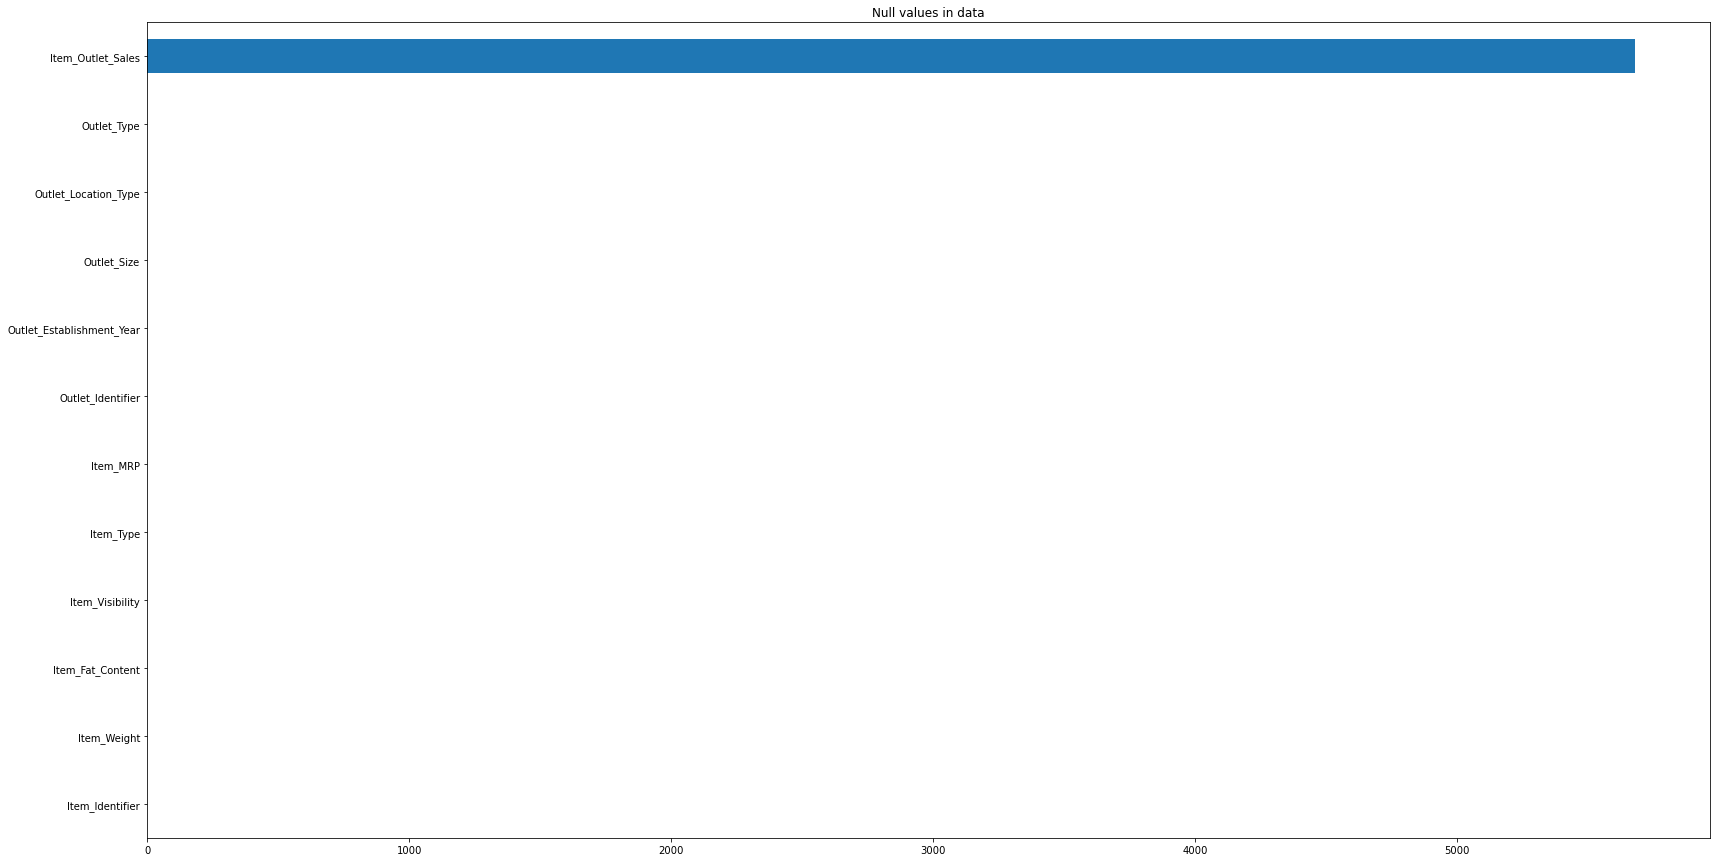

In [7]:
fig = plt.subplots(figsize = (28, 15))
plt.title('Null values in data')
null.plot(kind='barh');

There are more number of missing values in sales column. If we do missing value imputation it may increase bias in the data therefore the data is needed to be splitted into two parts so that we train the model with given sales values and predict the unknown sales using the model.

In [8]:
#splitting data without null values
train_data=data.dropna() 
#train_data.to_csv('Regression_train_data.csv')
train_data

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FDA15        9.300          Low Fat         0.016047   
1              DRC01        5.920          Regular         0.019278   
2              FDN15       17.500          Low Fat         0.016760   
3              FDX07       19.200          Regular         0.074402   
4              NCD19        8.930          Low Fat         0.064299   
...              ...          ...              ...              ...   
8518           FDF22        6.865          Low Fat         0.056783   
8519           FDS36        8.380          Regular         0.046982   
8520           NCJ29       10.600          Low Fat         0.035186   
8521           FDN46        7.210          Regular         0.145221   
8522           DRG01       14.800          Low Fat         0.044878   

                  Item_Type  Item_MRP Outlet_Identifier  \
0                     Dairy  249.8092            OUT049   
1               Soft Drinks   48.2692            OUT018   
2                      Meat  141.6180            OUT049   
3     Fruits and Vegetables  182.0950            OUT010   
4                 Household   53.8614            OUT013   
...                     ...       ...               ...   
8518            Snack Foods  214.5218            OUT013   
8519           Baking Goods  108.1570            OUT045   
8520     Health and Hygiene   85.1224            OUT035   
8521            Snack Foods  103.1332            OUT018   
8522            Soft Drinks   75.4670            OUT046   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                          1999      Medium               Tier 1   
1                          2009      Medium               Tier 3   
2                          1999      Medium               Tier 1   
3                          1998      Medium               Tier 3   
4                          1987        High               Tier 3   
...                         ...         ...                  ...   
8518                       1987        High               Tier 3   
8519                       2002       Small               Tier 2   
8520                       2004       Small               Tier 2   
8521                       2009      Medium               Tier 3   
8522                       1997       Small               Tier 1   

            Outlet_Type  Item_Outlet_Sales  
0     Supermarket Type1          3735.1380  
1     Supermarket Type2           443.4228  
2     Supermarket Type1          2097.2700  
3         Grocery Store           732.3800  
4     Supermarket Type1           994.7052  
...                 ...                ...  
8518  Supermarket Type1          2778.3834  
8519  Supermarket Type1           549.2850  
8520  Supermarket Type1          1193.1136  
8521  Supermarket Type2          1845.5976  
8522  Supermarket Type1           765.6700  

[8523 rows x 12 columns]

In [9]:
#splitting data with null values
test_data=data[data['Item_Outlet_Sales'].isnull()]
test_data.drop('Item_Outlet_Sales',axis=1,inplace=True)
test_data

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
8523            FDW58       20.750          Low Fat         0.007565   
8524            FDW14        8.300          Regular         0.038428   
8525            NCN55       14.600          Low Fat         0.099575   
8526            FDQ58        7.315          Low Fat         0.015388   
8527            FDY38       13.600          Regular         0.118599   
...               ...          ...              ...              ...   
14199           FDB58       10.500          Regular         0.013496   
14200           FDD47        7.600          Regular         0.142991   
14201           NCO17       10.000          Low Fat         0.073529   
14202           FDJ26       15.300          Regular         0.064709   
14203           FDU37        9.500          Regular         0.104720   

                Item_Type  Item_MRP Outlet_Identifier  \
8523          Snack Foods  107.8622            OUT049   
8524                Dairy   87.3198            OUT017   
8525               Others  241.7538            OUT010   
8526          Snack Foods  155.0340            OUT017   
8527                Dairy  234.2300            OUT027   
...                   ...       ...               ...   
14199         Snack Foods  141.3154            OUT046   
14200       Starchy Foods  169.1448            OUT018   
14201  Health and Hygiene  118.7440            OUT045   
14202              Canned  214.6218            OUT017   
14203              Canned   79.7960            OUT045   

       Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
8523                        1999      Medium               Tier 1   
8524                        2007       Small               Tier 2   
8525                        1998      Medium               Tier 3   
8526                        2007       Small               Tier 2   
8527                        1985      Medium               Tier 3   
...                          ...         ...                  ...   
14199                       1997       Small               Tier 1   
14200                       2009      Medium               Tier 3   
14201                       2002       Small               Tier 2   
14202                       2007       Small               Tier 2   
14203                       2002       Small               Tier 2   

             Outlet_Type  
8523   Supermarket Type1  
8524   Supermarket Type1  
8525       Grocery Store  
8526   Supermarket Type1  
8527   Supermarket Type3  
...                  ...  
14199  Supermarket Type1  
14200  Supermarket Type2  
14201  Supermarket Type1  
14202  Supermarket Type1  
14203  Supermarket Type1  

[5681 rows x 11 columns]

In [10]:
train_data.shape #shape of train data

(8523, 12)

In [11]:
test_data.shape #shape of test data

(5681, 11)

In [12]:
#Splitting item identifier name from data
train_data['Item_Identifier']=train_data['Item_Identifier'].apply(lambda x:x[:2]) 
test_data['Item_Identifier']=test_data['Item_Identifier'].apply(lambda x:x[:2])
train_data['Item_Identifier'].unique()

array(['FD', 'DR', 'NC'], dtype=object)

In [13]:
#Renaming item identifier name
train_data.replace({'Item_Identifier':{'FD':'Food','NC':'Non-Consumable','DR':'Drinks'}},inplace=True)
test_data.replace({'Item_Identifier':{'FD':'Food','NC':'Non-Consumable','DR':'Drinks'}},inplace=True)
train_data['Item_Identifier'].unique()

array(['Food', 'Drinks', 'Non-Consumable'], dtype=object)

In [14]:
#dropping these columns because of noise in data
train_data.drop(['Outlet_Establishment_Year','Outlet_Identifier'],axis=1,inplace=True)
test_data.drop(['Outlet_Establishment_Year','Outlet_Identifier'],axis=1,inplace=True)

## Exploratory Data Analysis

#### Distribution of sales

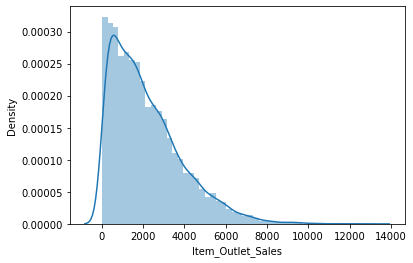

In [15]:
sns.distplot(train_data['Item_Outlet_Sales']);

More number of sales lies less than 2000 and the data is right skewed. 

#### Outlier of sales

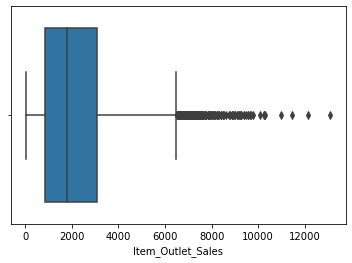

In [16]:
sns.boxplot(train_data['Item_Outlet_Sales']);

There are outliers present in data.

#### Distribution of item price

<AxesSubplot:xlabel='Item_MRP', ylabel='Density'>

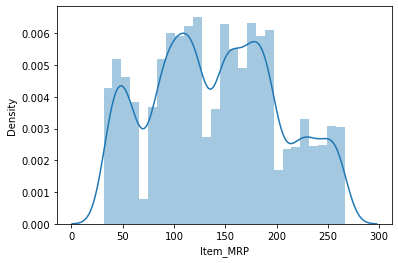

In [17]:
sns.distplot(train_data['Item_MRP'])

 Item price is normally distributed and has no skewness in data.

#### Distribution of item weight

<AxesSubplot:xlabel='Item_Weight', ylabel='Density'>

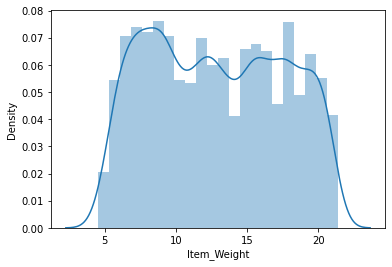

In [18]:
sns.distplot(train_data['Item_Weight'])

Item weight is normally distributed and has no skewness in data.

 #### Location wise sales 

In [19]:
tier_sales=pd.pivot_table(data=train_data,index='Outlet_Location_Type',values='Item_Outlet_Sales',aggfunc=sum).sort_values('Item_Outlet_Sales',ascending=False)
tier_sales.reset_index(inplace=True)

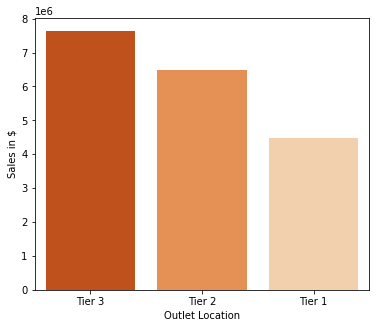

In [20]:
plt.figure(figsize=(6,5))
sns.barplot(x=tier_sales['Outlet_Location_Type'],y=tier_sales['Item_Outlet_Sales'],palette='Oranges_r')
plt.xlabel('Outlet Location')
plt.ylabel('Sales in $');

From this plot we can see Tier 3 location has high number of sales.

#### Location wise availability of outlet

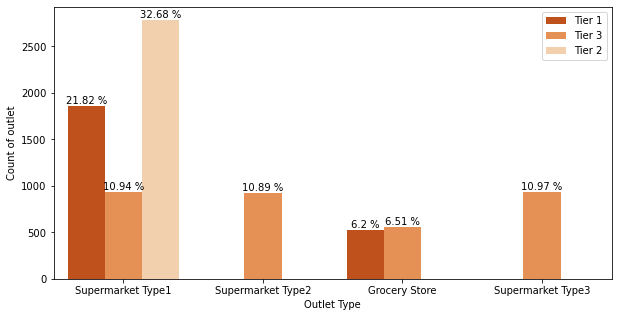

In [21]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(x=train_data['Outlet_Type'],hue=train_data['Outlet_Location_Type'],palette='Oranges_r')
plt.legend(loc='upper right')
plt.xlabel('Outlet Type')
plt.ylabel('Count of outlet')
for bar in ax.patches:                                                  
    percentage = f"{round((bar.get_height() /train_data.shape[0])*100 , 2)} %"  
    x = bar.get_x() + bar.get_width() /2                               
    y = bar.get_height()                                               
    ax.annotate(percentage, (x, y), va= "bottom", ha = "center" );

Here we can see Tier 3 location has its outlets distributed in all categories but Tier 1 & 2 location has setup their outlets across one or two outlet categories which resulted in low sales.   

#### Outlet size wise sales

In [22]:
size_sales=pd.pivot_table(data=train_data,index='Outlet_Size',values='Item_Outlet_Sales',aggfunc=sum).sort_values('Item_Outlet_Sales',ascending=False)
size_sales.reset_index(inplace=True)

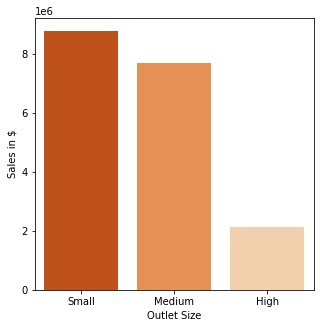

In [23]:
plt.figure(figsize=(5,5))
sns.barplot(x=size_sales['Outlet_Size'],y=size_sales['Item_Outlet_Sales'],palette='Oranges_r')
plt.xlabel('Outlet Size')
plt.ylabel('Sales in $');

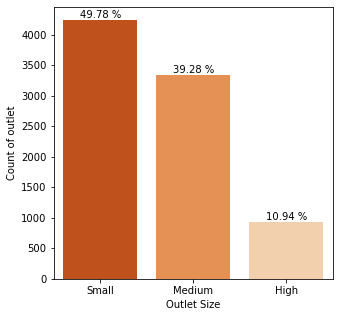

In [24]:
fig, ax = plt.subplots(figsize = (5, 5))
sns.countplot(x=train_data['Outlet_Size'],palette='Oranges_r',order=['Small','Medium','High'])
plt.xlabel('Outlet Size')
plt.ylabel('Count of outlet')
for bar in ax.patches:                                                  
    percentage = f"{round((bar.get_height() /train_data.shape[0])*100 , 2)} %"  
    x = bar.get_x() + bar.get_width() /2                               
    y = bar.get_height()                                               
    ax.annotate(percentage, (x, y), va= "bottom", ha = "center" );

Small size outlet tend to have more sales because of the count of these outlets are high.

#### Item wise sales

In [25]:
tier1=train_data[train_data['Outlet_Location_Type']=='Tier 1']
tier2=train_data[train_data['Outlet_Location_Type']=='Tier 2']
tier3=train_data[train_data['Outlet_Location_Type']=='Tier 3']

In [26]:
tier1_item=pd.pivot_table(data=tier1,index='Item_Type',values='Item_Outlet_Sales',aggfunc=sum).sort_values('Item_Outlet_Sales',ascending=False)
tier2_item=pd.pivot_table(data=tier2,index='Item_Type',values='Item_Outlet_Sales',aggfunc=sum).sort_values('Item_Outlet_Sales',ascending=False)
tier3_item=pd.pivot_table(data=tier3,index='Item_Type',values='Item_Outlet_Sales',aggfunc=sum).sort_values('Item_Outlet_Sales',ascending=False)

In [27]:
tier1_item.reset_index(inplace=True)
tier2_item.reset_index(inplace=True)
tier3_item.reset_index(inplace=True)

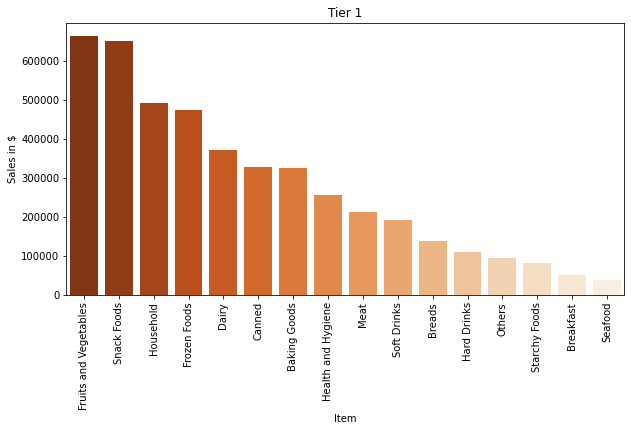

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(x=tier1_item['Item_Type'],y=tier1_item['Item_Outlet_Sales'],palette='Oranges_r')
plt.title('Tier 1')
plt.xlabel('Item')
plt.ylabel('Sales in $')
plt.xticks(rotation=90);

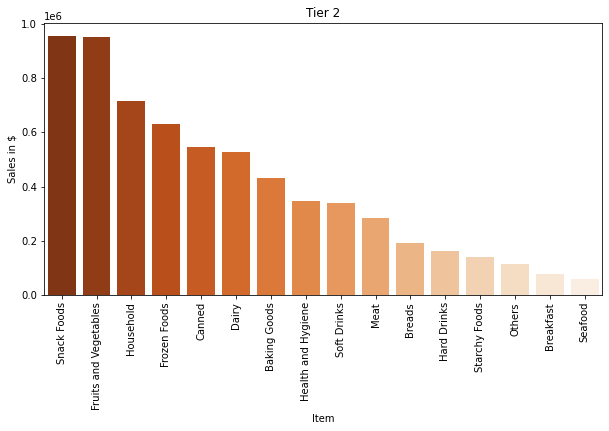

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x=tier2_item['Item_Type'],y=tier2_item['Item_Outlet_Sales'],palette='Oranges_r')
plt.title('Tier 2')
plt.xlabel('Item')
plt.ylabel('Sales in $')
plt.xticks(rotation=90);

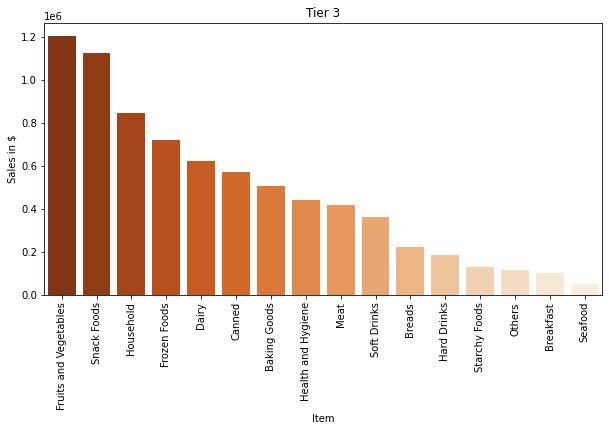

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(x=tier3_item['Item_Type'],y=tier3_item['Item_Outlet_Sales'],palette='Oranges_r')
plt.title('Tier 3')
plt.xlabel('Item')
plt.ylabel('Sales in $')
plt.xticks(rotation=90);

   When analyzing all locations we can see fruits & vegetables, snack foods and household are highly sold products.

#### Item wise visibility

In [31]:
item_visibility=pd.pivot_table(data=train_data,index='Item_Type',values='Item_Visibility',aggfunc='mean').sort_values('Item_Visibility',ascending=False)
item_visibility.reset_index(inplace=True)

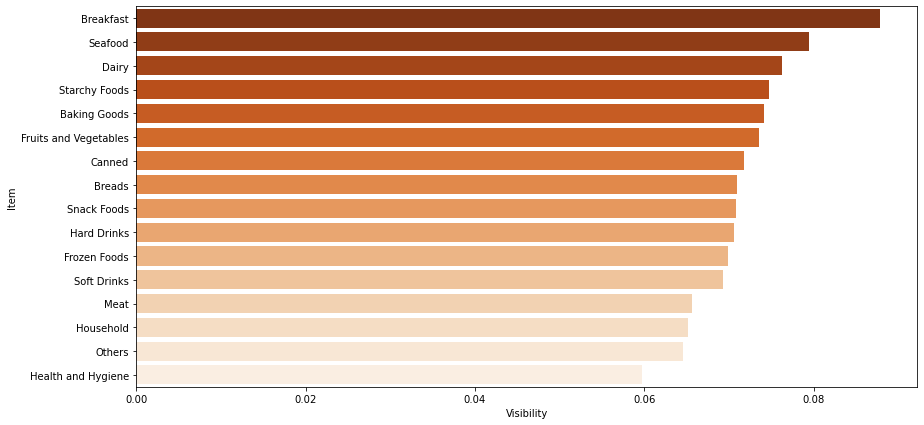

In [32]:
plt.figure(figsize=(14,7))
sns.barplot(y=item_visibility['Item_Type'],x=item_visibility['Item_Visibility'],palette='Oranges_r')
plt.xlabel('Visibility')
plt.ylabel('Item');

Comparing with the previous chart here we can see the highly sold items have low visibility so increasing them may have an increase in overall sales.

#### Relation between sales and item price

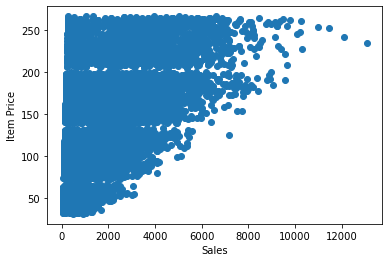

In [33]:
plt.scatter(train_data['Item_Outlet_Sales'],train_data['Item_MRP'])
plt.xlabel('Sales')
plt.ylabel('Item Price');

There is a positive relation between item price and sales.

#### Relation between sales and item visibility

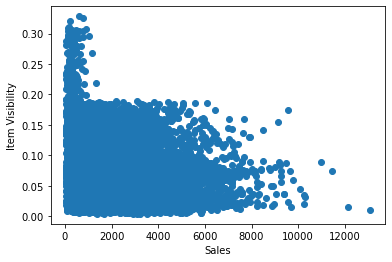

In [34]:
plt.scatter(train_data['Item_Outlet_Sales'],train_data['Item_Visibility'])
plt.xlabel('Sales')
plt.ylabel('Item Visibility');

There is a negative relation between sales and item visibility.

#### Relation between sales and item weight

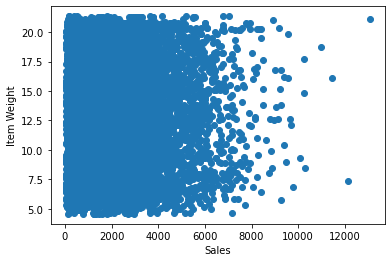

In [35]:
plt.scatter(train_data['Item_Outlet_Sales'],train_data['Item_Weight'])
plt.xlabel('Sales')
plt.ylabel('Item Weight');

There is no relation between sales and item weight.

In [36]:
profile=ProfileReport(train_data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

In [37]:
#splitting nominal and ordinal features
nominal=['Item_Identifier','Item_Type']
ordinal=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type']

In [38]:
#applying one hot encoding for nominal data
item_identifier1=pd.get_dummies(train_data['Item_Identifier'])
item_identifier2=pd.get_dummies(test_data['Item_Identifier'])
item_type1=pd.get_dummies(train_data['Item_Type'])
item_type2=pd.get_dummies(test_data['Item_Type'])

In [39]:
#concating one hot encoded columns with data
train_data=pd.concat([train_data,item_identifier1],axis=1,join='inner')
test_data=pd.concat([test_data,item_identifier2],axis=1,join='inner')
train_data=pd.concat([train_data,item_type1],axis=1,join='inner')
test_data=pd.concat([test_data,item_type2],axis=1,join='inner')

In [40]:
#dropping one hot encoded columns from data
train_data.drop(nominal,axis=1,inplace=True)
test_data.drop(nominal,axis=1,inplace=True)

In [41]:
#applying label encoding for ordinal data
for i in ordinal:
    train_data[i]=train_data[i].astype('category')
for i in ordinal:
    train_data[i]=LabelEncoder().fit_transform(train_data[i])
for i in ordinal:
    test_data[i]=test_data[i].astype('category')
for i in ordinal:
    test_data[i]=LabelEncoder().fit_transform(test_data[i])

## Feature Scaling

In [42]:
#scaling feature using standard scaler
scaler=StandardScaler() 
train_s=pd.DataFrame(scaler.fit_transform(train_data.to_numpy()),columns=train_data.columns)
test_s=pd.DataFrame(scaler.fit_transform(test_data.to_numpy()),columns=test_data.columns)

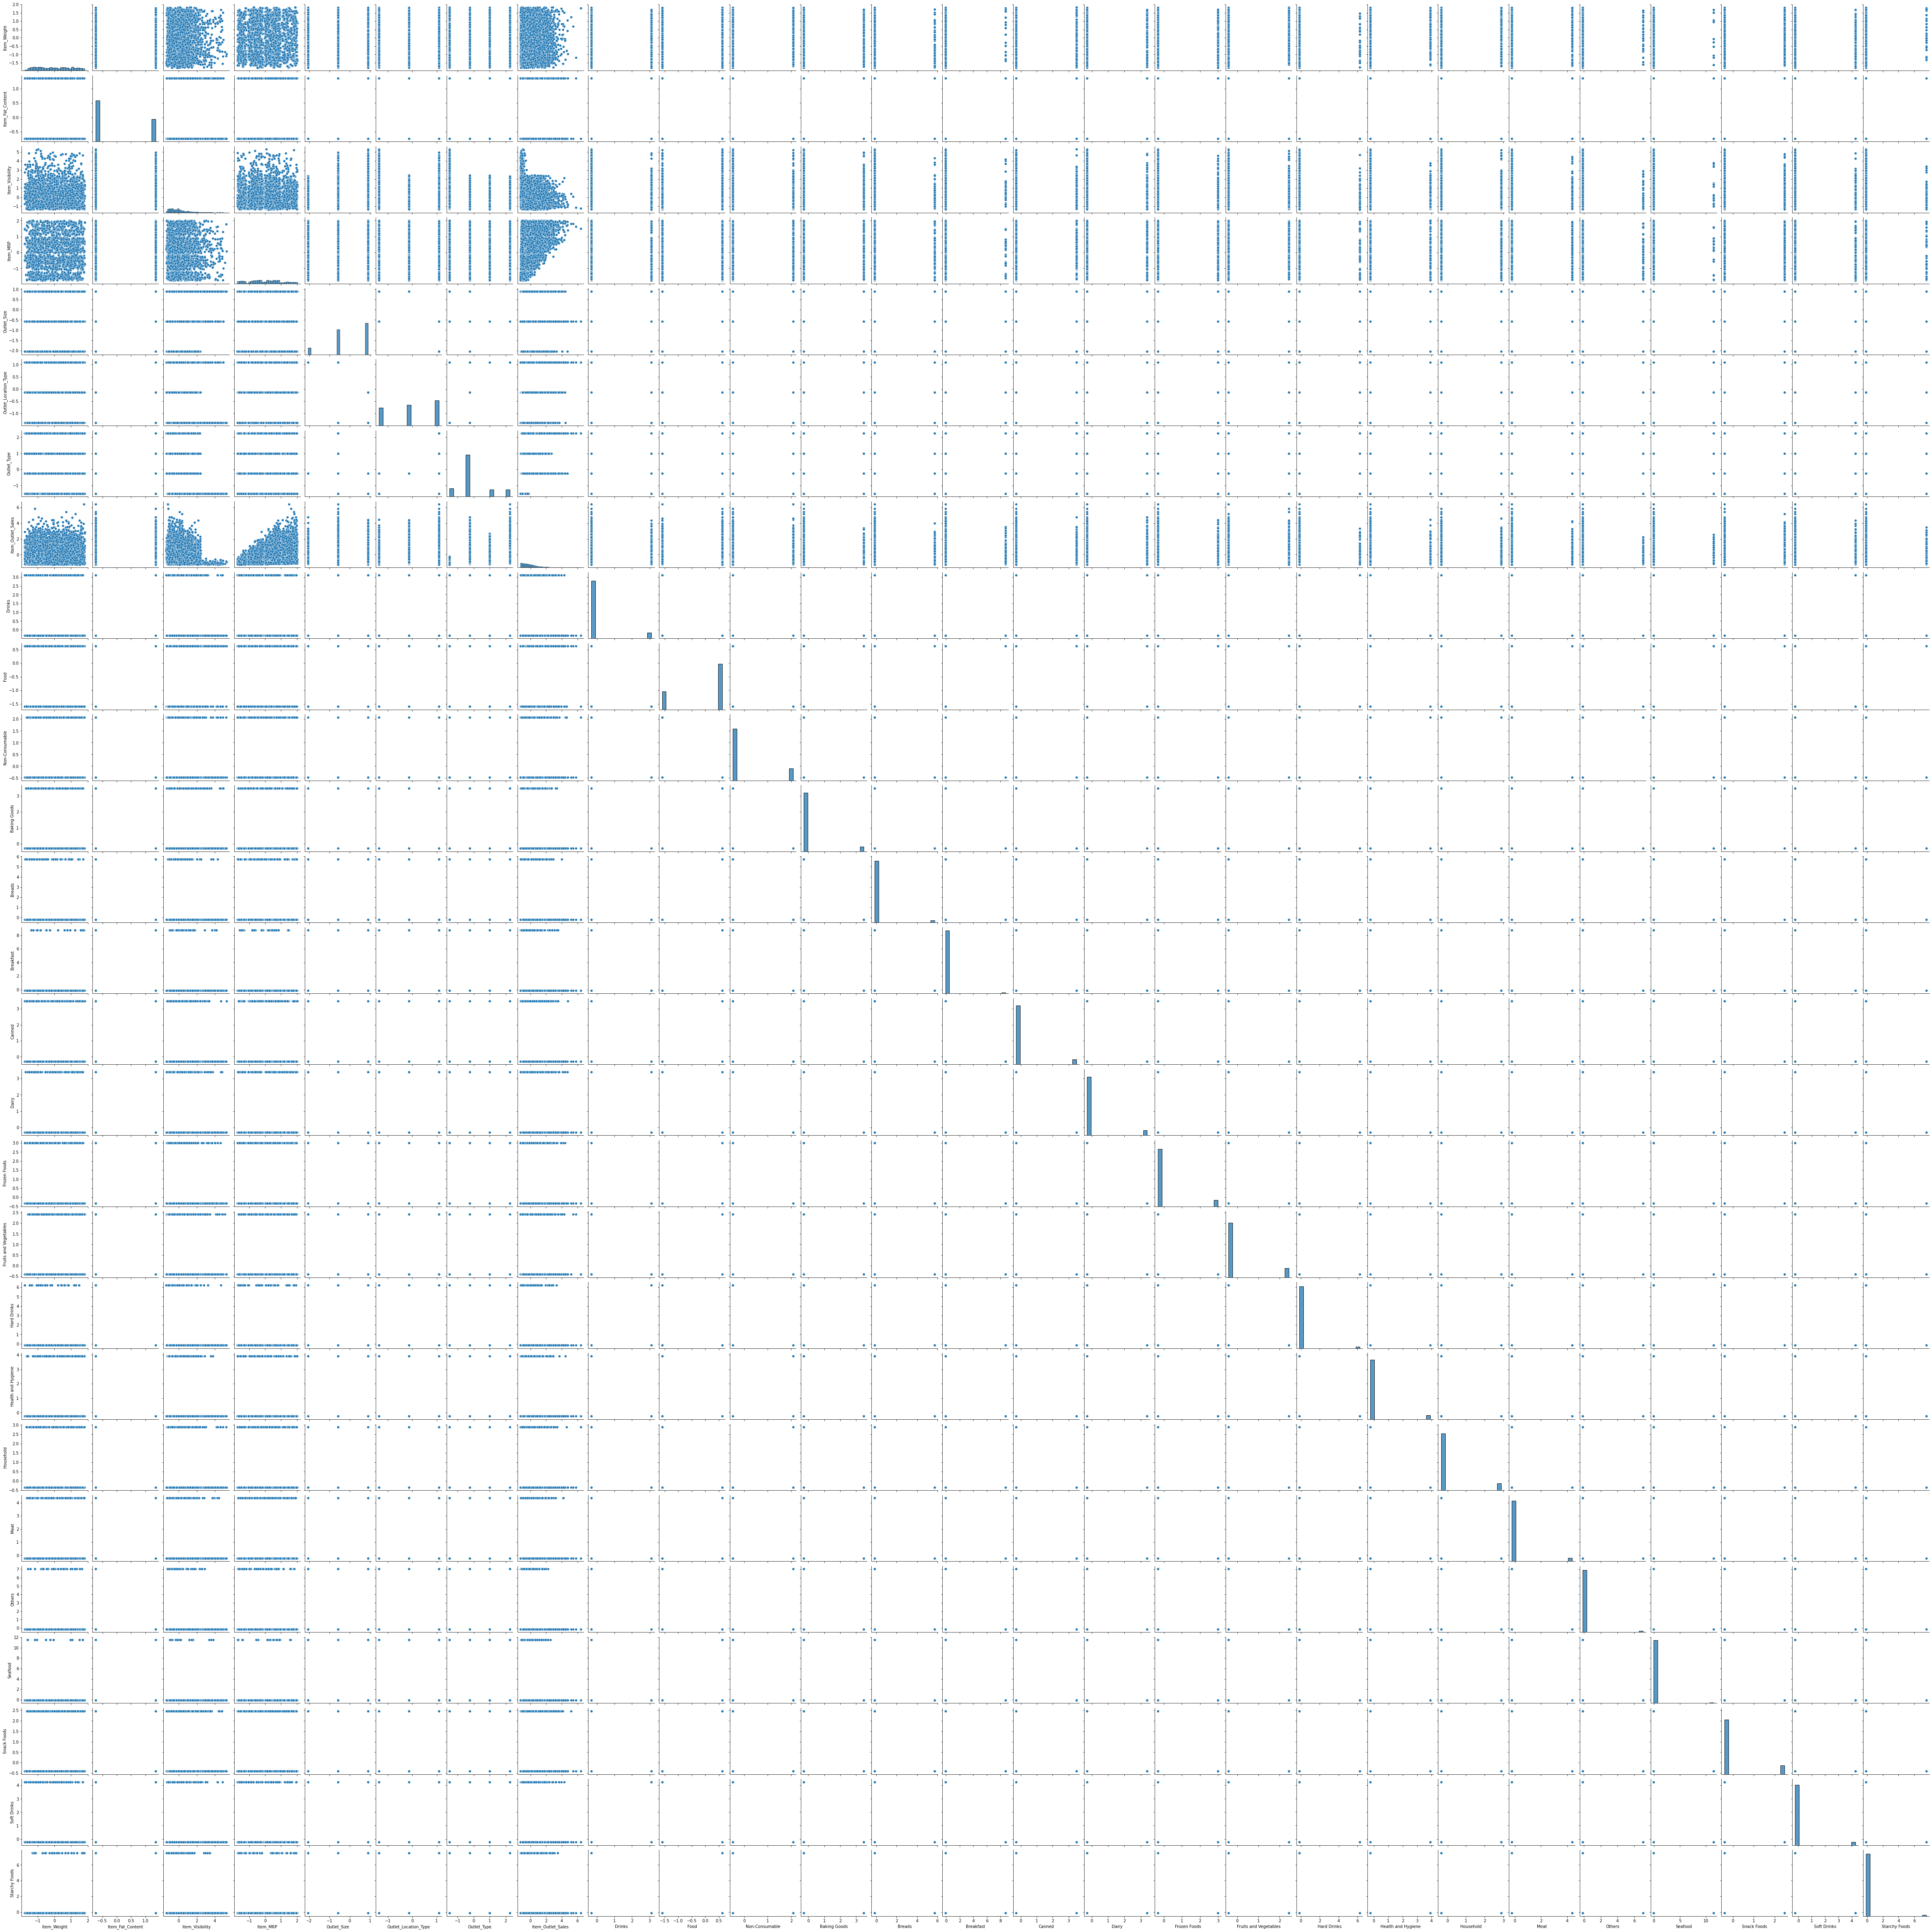

In [43]:
sns.pairplot(train_s); #pair plot for scaled data

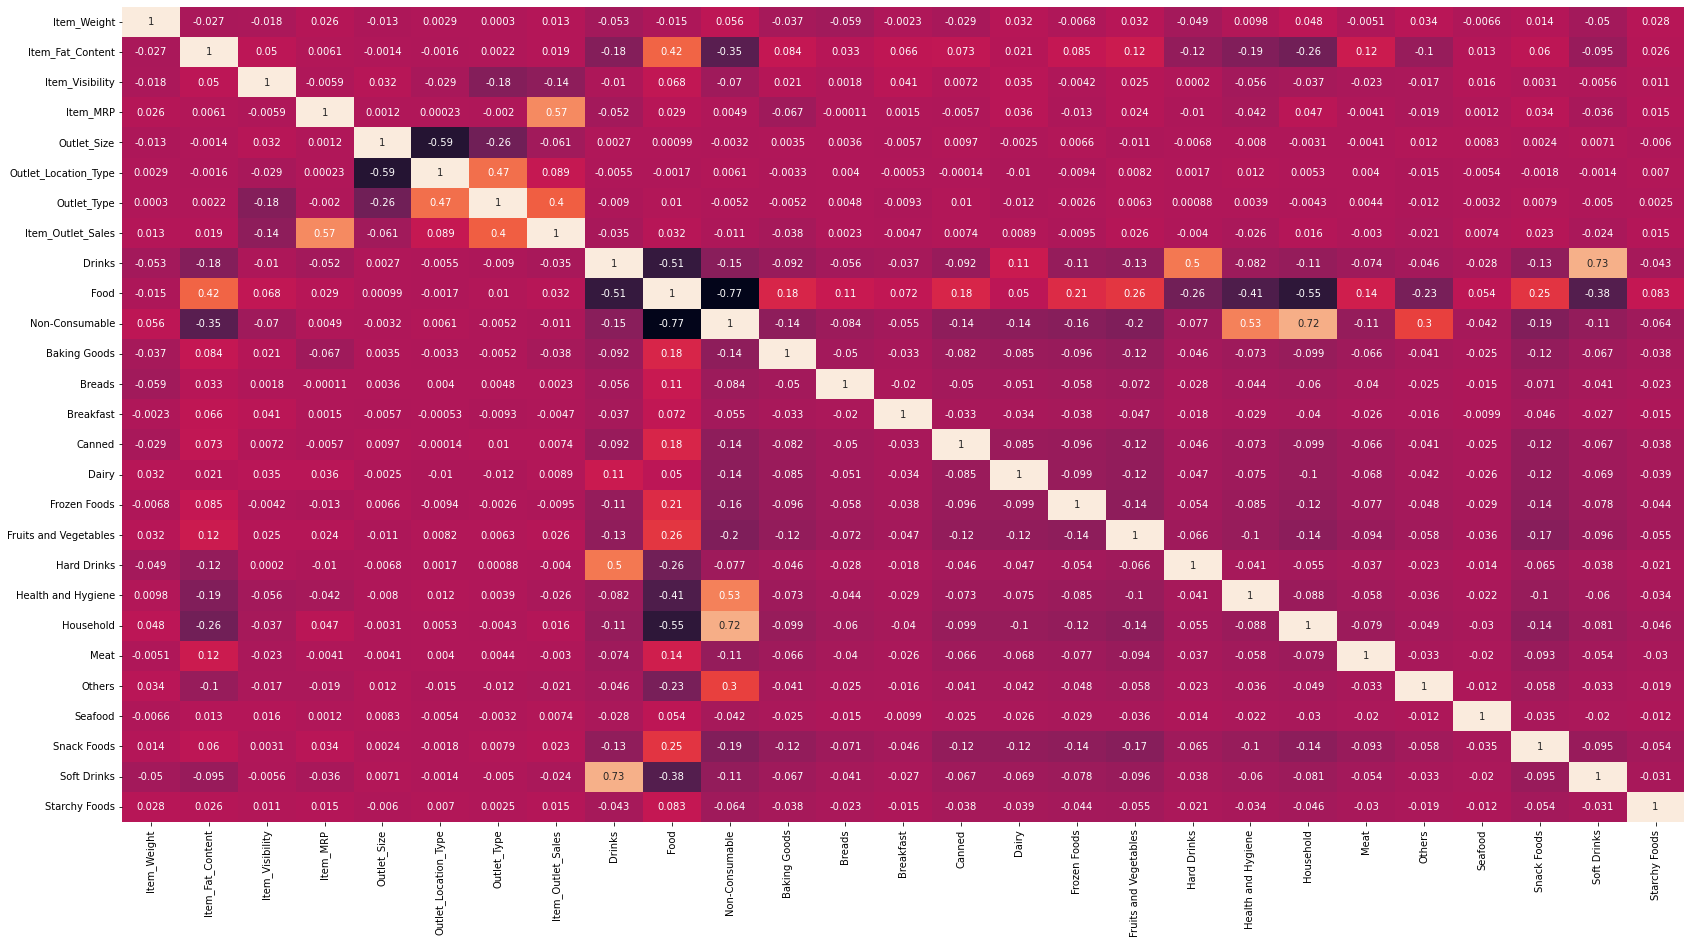

In [44]:
#corellation chart
data_corr=train_s.corr()
fig = plt.subplots(figsize = (28, 15))
sns.heatmap(data_corr,annot=True,cbar=False);

In [45]:
#corelation with target column
correlation=abs(data_corr['Item_Outlet_Sales']).sort_values(ascending=False)
correlation=correlation.to_frame()
correlation.reset_index(inplace=True)
correlation

index  Item_Outlet_Sales
0       Item_Outlet_Sales           1.000000
1                Item_MRP           0.567574
2             Outlet_Type           0.401522
3         Item_Visibility           0.135247
4    Outlet_Location_Type           0.089367
5             Outlet_Size           0.060517
6            Baking Goods           0.038381
7                  Drinks           0.034672
8                    Food           0.031905
9   Fruits and Vegetables           0.025950
10     Health and Hygiene           0.025587
11            Soft Drinks           0.024040
12            Snack Foods           0.022782
13                 Others           0.021267
14       Item_Fat_Content           0.018719
15              Household           0.015701
16          Starchy Foods           0.015039
17            Item_Weight           0.013261
18         Non-Consumable           0.010861
19           Frozen Foods           0.009482
20                  Dairy           0.008858
21                 Canned           0.007387
22                Seafood           0.007380
23              Breakfast           0.004656
24            Hard Drinks           0.003956
25                   Meat           0.002995
26                 Breads           0.002332

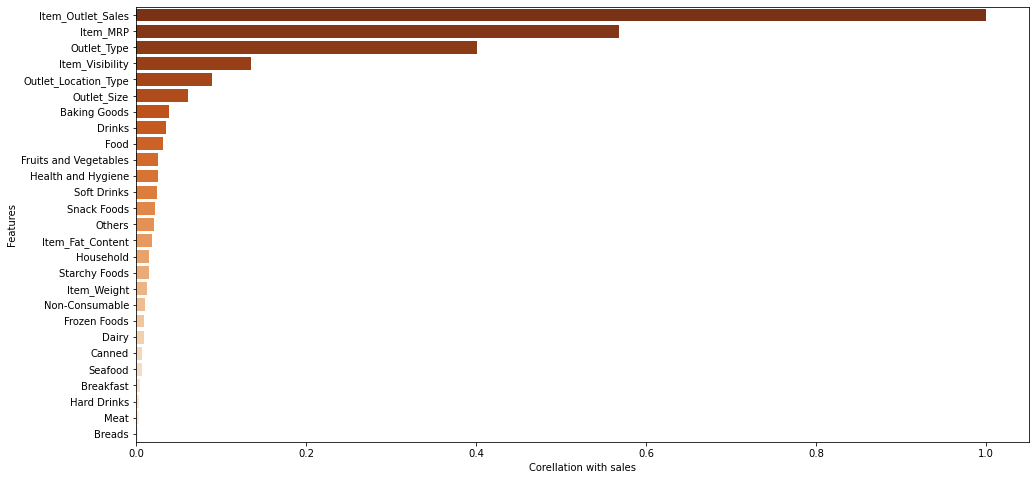

In [46]:
plt.figure(figsize=(16,8))
sns.barplot(y=correlation['index'],x=correlation['Item_Outlet_Sales'],palette='Oranges_r')
plt.xlabel('Corellation with sales')
plt.ylabel('Features');

## Splitting dependent and independent columns

In [47]:
x=train_data.drop('Item_Outlet_Sales',axis=1).to_numpy()
y=train_data['Item_Outlet_Sales'].to_numpy()
x1=train_s.drop('Item_Outlet_Sales',axis=1)
x2=x1.to_numpy()
y1=train_s['Item_Outlet_Sales'].to_numpy()

## Feature Selection 

In [48]:
#splitting highly corellated features
features=x1[['Item_MRP','Outlet_Type','Item_Visibility']] 

## Model Building

In [49]:
#cross validation for data splitting
cv = KFold(n_splits=3, shuffle=True, random_state=1) #splitting data

In [50]:
#splitting train data into train test pairs
for train, test in cv.split(x,y):
  x_train, x_test=x[train],x[test]
  y_train, y_test=y[train],y[test]

In [51]:
#splitting test data into train test pairs
for train, test in cv.split(x2,y1):
  x1_train, x1_test=x[train],x[test]
  y1_train, y1_test=y[train],y[test]

In [52]:
#function for doing randomized search
def random(x,y,model,parameters,cv):
  random_search = RandomizedSearchCV(model,param_distributions=parameters,cv = cv, scoring='r2',random_state=42)
  random_search.fit(x,y)
  print('Best Score :',random_search.best_score_)
  print('Best Estimator :',random_search.best_params_)

In [53]:
#function for cross validation
def validate(x,y,model,cv):
  scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error','neg_median_absolute_error']
  scores=cross_validate(model, x, y, scoring=scoring, cv=cv)
  return scores

In [54]:
#function for returning cross validated scores
def scores (score):
  s1=(score['test_r2'])
  s2=(score['test_neg_mean_squared_error'])
  s3=(score['test_neg_root_mean_squared_error'])
  s4=(score['test_neg_mean_absolute_percentage_error'])
  s5=(score['test_neg_median_absolute_error'])
  return(s1,s2,s3,s4,s5)

#### Linear Regression

In [55]:
model1=LinearRegression() #importing model

In [56]:
scores1 = validate(features,y1,model1,cv) #model evaluation

In [57]:
fit=model1.fit(x1_train, y1_train) #fitting model
y_pred=fit.predict(x1_test) #predicting values
r_sq=fit.score(x1_train, y1_train) #geting train r sq 
test_r_sq = fit.score(x1_test,y1_test) #geting test r sq 
print('Train R^2 :', r_sq)
print('Test R^2 :', test_r_sq)

Train R^2 : 0.499596461810644
Test R^2 : 0.5012440568922352


There is no overfitting in the model.

In [58]:
m1s1,m1s2,m1s3,m1s4,m1s5=scores(scores1) #getting cross validated scores

In [59]:
print(f'''r2:{mean(m1s1)}
MSE:{mean(m1s2)}
RMSE:{mean(m1s3)}
MAPE:{mean(m1s4)}
MAE:{mean(m1s5)}''')

r2:0.48747780175980004
MSE:-0.512525712924396
RMSE:-0.715874629534313
MAPE:-5.953344809400369
MAE:-0.41714466679849665


From the above r square value we can say that model is underfitting i.e. high bias. Therefore it is preferred to use a boosting ensemble technique.

#### XGB Regressor

In [60]:
m2 = xgboost.XGBRegressor(random_state=42) #importing model
params2 = {'learning_rate': [0.05,0.10,0.15,0.20,0.25,0.30],'max_depth': [2,3,5,10,20],'gamma':[0.0,0.1,0.2,0.3,0.4],'min_child_weight':[1,3,5,7],'colsample_bytree':[0.3,0.4,0.5,0.7]}
random(x,y,m2,params2,cv) #applying randomized search

Best Score : 0.5941175903294938
Best Estimator : {'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [61]:
 #building model using tuned hyper parameters
model2 = xgboost.XGBRegressor(colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=2, min_child_weight=5, random_state=42)

In [62]:
scores2 = validate(x1,y1,model2,cv) #model evaluation

In [63]:
fit2=model2.fit(x_train, y_train) #fitting model
y2_pred=fit2.predict(x_test) #predicting values
r_sq=fit2.score(x_train, y_train) #geting train r sq 
test_r_sq = fit2.score(x_test,y_test) #geting test r sq 
print('Train R^2 :', r_sq)
print('Test R^2 :', test_r_sq)

Train R^2 : 0.6145774824148296
Test R^2 : 0.5976609099679797


There is no overfitting in the model.

In [64]:
m2s1,m2s2,m2s3,m2s4,m2s5=scores(scores2) #getting cross validated scores

In [65]:
print(f'''r2:{mean(m2s1)}
MSE:{mean(m2s2)}
RMSE:{mean(m2s3)}
MAPE:{mean(m2s4)}
MAE:{mean(m2s5)}''')

r2:0.5940751985031149
MSE:-0.4058817281783886
RMSE:-0.6370748058283874
MAPE:-5.500443327809433
MAE:-0.30780636716774573


From the above r square value we can see that the performance has increased through boosting technique.

#### Comparison of models

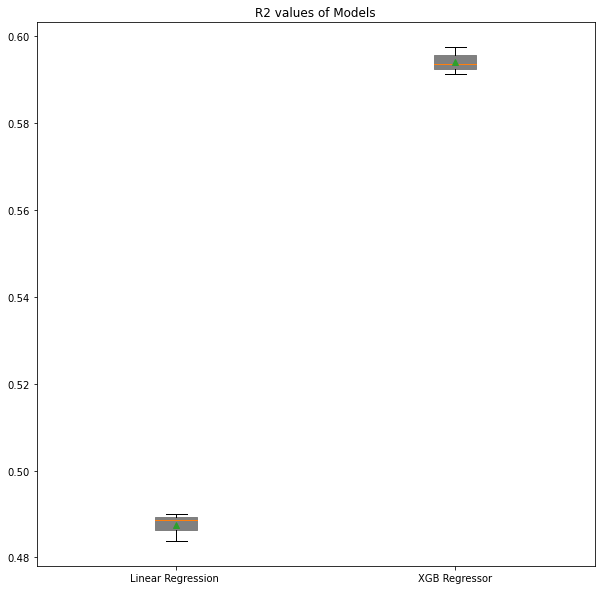

In [66]:
# comparing r2 values
names=['Linear Regression ','XGB Regressor']
fig, ax = plt.subplots(figsize = (10, 10))
plt.title('R2 values of Models')
plt.boxplot([m1s1,m2s1], labels=names, showmeans=True, patch_artist=True ,boxprops=dict(facecolor='grey',color='grey'));

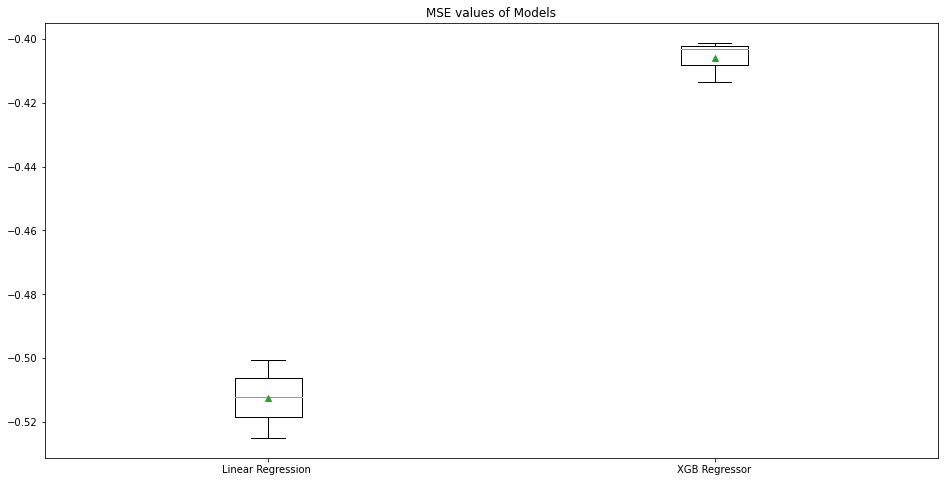

In [67]:
#comparing mse values
fig, ax = plt.subplots(figsize = (16, 8))
plt.title('MSE values of Models')
plt.boxplot([m1s2,m2s2], labels=names, showmeans=True);

XGB regressor has less MSE values.

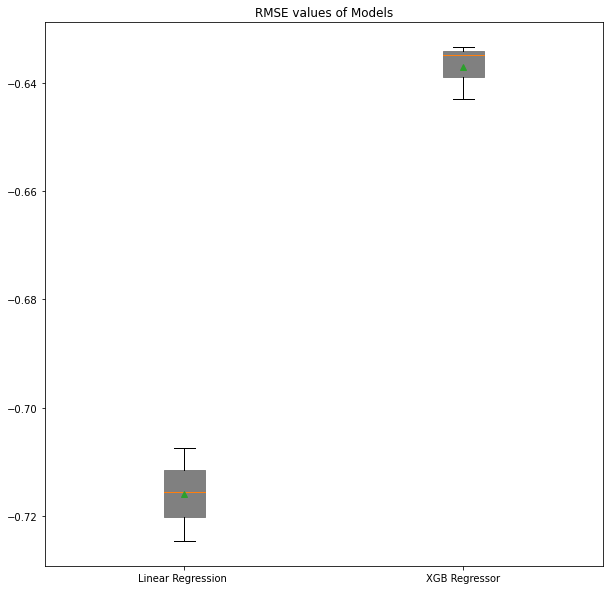

In [68]:
#comparing rmse values
fig, ax = plt.subplots(figsize = (10, 10))
plt.title('RMSE values of Models')
plt.boxplot([m1s3,m2s3], labels=names, showmeans=True, patch_artist=True ,boxprops=dict(facecolor='grey',color='grey'));

XGB regressor has less RMSE values.

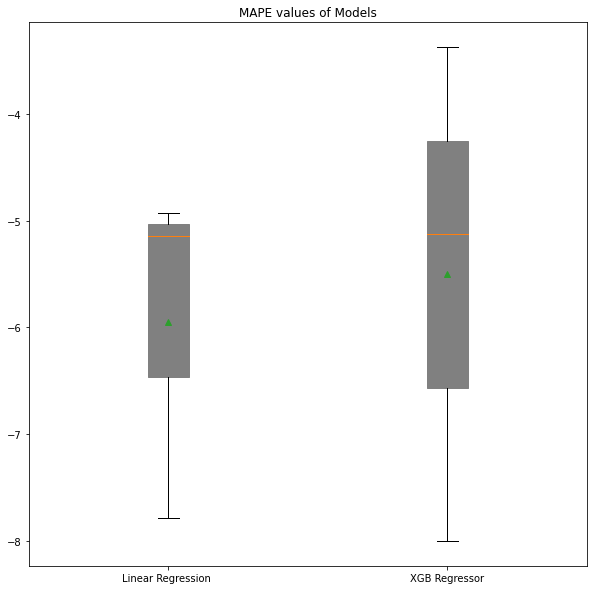

In [69]:
#comparing mape values
fig, ax = plt.subplots(figsize = (10, 10))
plt.title('MAPE values of Models')
plt.boxplot([m1s4,m2s4], labels=names, showmeans=True, patch_artist=True ,boxprops=dict(facecolor='grey',color='grey'));

XGB regressor has low average MAPE value compared to Linear regression.

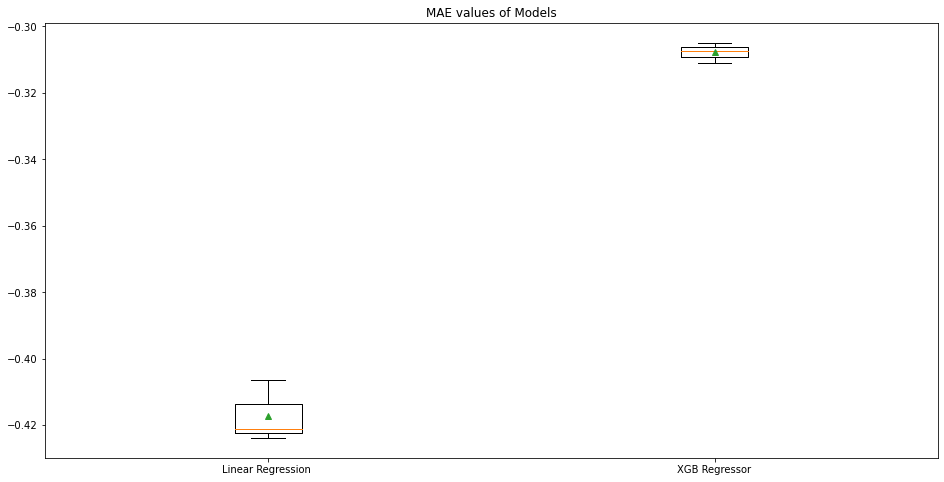

In [70]:
#comparing mae values
fig, ax = plt.subplots(figsize = (16, 8))
plt.title('MAE values of Models')
plt.boxplot([m1s5,m2s5], labels=names, showmeans=True);

XGB regressor has less MAE values.

In [71]:
#tabulation
comp=pd.DataFrame()
comp['Model']=['Linear Regression','XGB Regressor']
comp['R2']=[mean(m1s1),mean(m2s1)]
comp['MSE']=[mean(m1s2),mean(m2s2)]
comp['RMSE']=[mean(m1s3),mean(m2s3)]
comp['MAPE']=[mean(m1s4),mean(m2s4)]
comp['MAE']=[mean(m1s5),mean(m2s5)]
comp

Model        R2       MSE      RMSE      MAPE       MAE
0  Linear Regression  0.487478 -0.512526 -0.715875 -5.953345 -0.417145
1      XGB Regressor  0.594075 -0.405882 -0.637075 -5.500443 -0.307806

By comparing the above values we can see XGB Regressor has performed well.

#### Visualization of test and XGB Regressor predicted data

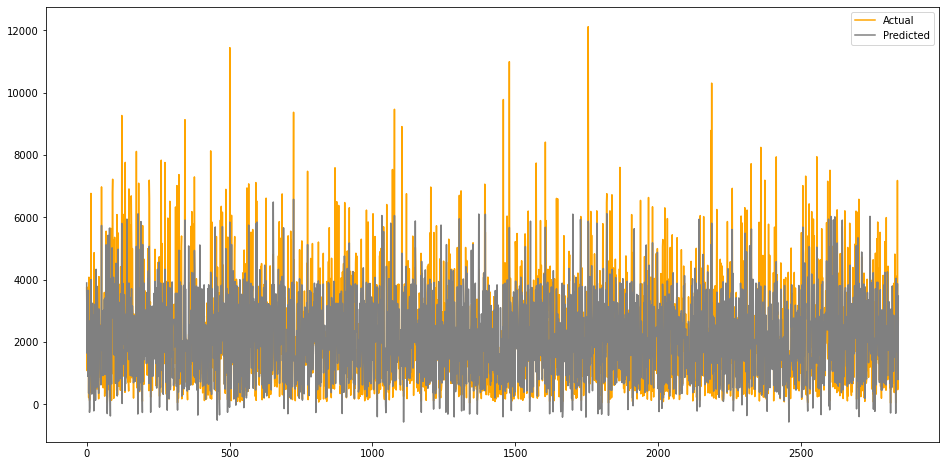

In [72]:
plt.figure(figsize=(16,8))
plt.plot(y_test,'orange',label='Actual')
plt.plot(y2_pred,label='Predicted',color='grey')
plt.legend();

we can see most of the values are predicted correctly by the model.

#### Distribution plot for difference between test and pedicted values

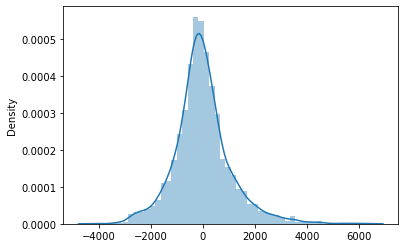

In [73]:
sns.distplot(y_test-y2_pred);

Errors are less and are normally distributed.

## Predicting test data using XGB Regressor

In [74]:
test_data=test_data.to_numpy()
y2_pred2=fit2.predict(test_data) #predicting values
y2_pred2

array([1380.5172 , 1472.7012 ,  835.14886, ..., 1919.8666 , 3616.5828 ,
       1367.5703 ], dtype=float32)

#### Distribution plot for predicted test data sales

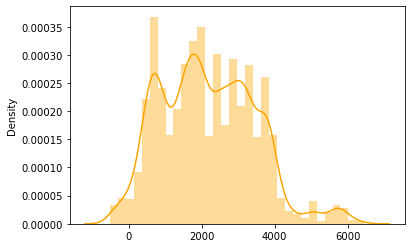

In [75]:
sns.distplot(y2_pred2,color='orange');

This data is slightly right skewed.

## Feature Importance as per model

In [76]:
feature_imp=pd.Series(model2.feature_importances_,(train_data.drop('Item_Outlet_Sales',axis=1)).columns).sort_values(ascending=False)
feature_imp=feature_imp.to_frame()
feature_imp.reset_index(inplace=True)
feature_imp

index         0
0             Outlet_Type  0.439449
1                Item_MRP  0.369680
2         Item_Visibility  0.041642
3                  Drinks  0.027987
4    Outlet_Location_Type  0.021723
5   Fruits and Vegetables  0.018768
6             Outlet_Size  0.017420
7             Snack Foods  0.017090
8             Item_Weight  0.008582
9            Baking Goods  0.008513
10       Item_Fat_Content  0.007176
11                 Others  0.005959
12                 Canned  0.005808
13                   Meat  0.003937
14          Starchy Foods  0.002862
15                   Food  0.002134
16              Breakfast  0.001270
17                  Dairy  0.000000
18           Frozen Foods  0.000000
19                 Breads  0.000000
20            Hard Drinks  0.000000
21     Health and Hygiene  0.000000
22              Household  0.000000
23         Non-Consumable  0.000000
24                Seafood  0.000000
25            Soft Drinks  0.000000

#### Visual Representation of feature importance

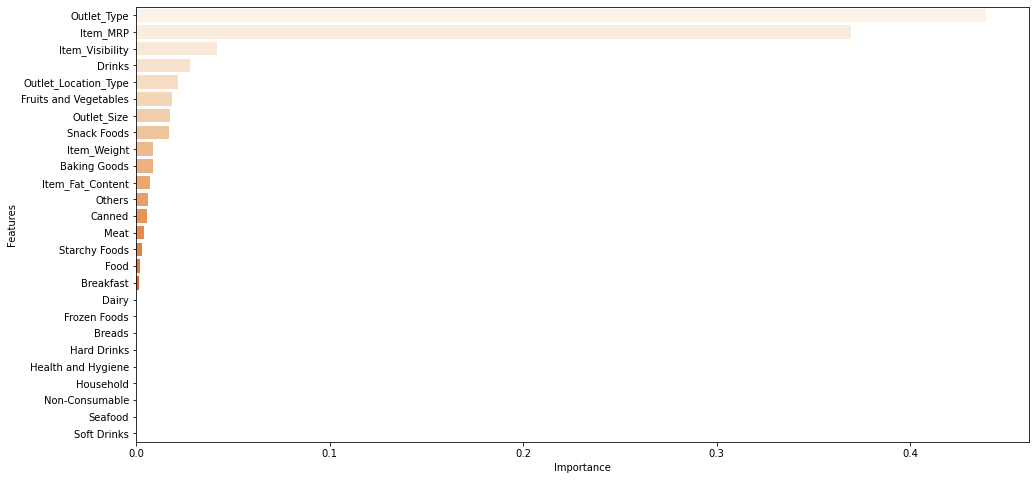

In [77]:
plt.figure(figsize=(16,8))
sns.barplot(y=feature_imp['index'],x=feature_imp[0],palette='Oranges')
plt.ylabel('Features')
plt.xlabel('Importance');

Outlet type and Item MRP are highly important in predicting the sales.

## Conclusion

Tier 3 location has it’s sales in high numbers due to presence of wide range of outlet in all categories.

Size of outlet proves that increased number of outlet has a positive impact on sales.

So it is suggested to open new outlet of different type in Tier 1 and Tier 2 location.

Items which are mostly sold has a low visibility rate.

Increasing the visibility rate of  fruits & vegetables, snacks and house hold will have an increase in overall sales.

Before implementing these changes business can use the machine learning model to get an idea on how these changes will create an impact on sales.

Thereby they can avoid upcoming losses and make changes in their proposal.